In [1]:
#export
import torch, math, logging, warnings, random, sys, io
import torch.nn as nn, numpy as np, matplotlib.pyplot as plt
from typing import Dict, Any, List, Union, Callable, overload, Tuple, Iterator\
, ContextManager

In [2]:
#export
__all__ = ["_docsUrl", "Object", "Range", "Domain", "AutoIncrement", "Wrapper",
           "CaptureStdout",
           "CancelRunException", "CancelEpochException", "CancelBatchException",
           "textToHtml", "clearLine", "tab", "isNumeric", "close", "stats",
           "patch", "squeeze", "raiseEx", "smooth", "numDigits", "limitLines",
           "limitChars", "showLog", "cleanDiv", "beep", "executeNb", "dontWrap",
           "Func", "polyfit", "derivative", "optimize", "inverse", "integrate",
           "ignoreWarnings", "positionalEncode", "debounce"]

In [3]:
#export
_docsUrl = "https://k1lib.github.io"

In [4]:
#export
class Object:
    """Convenience class that acts like ``defaultdict``. You can use
it like a normal object::

    a = Object()
    a.b = 3
    print(a.b) # outputs "3"

``__repr__()`` output is pretty nice too:

.. code-block:: text

    <class '__main__.Object'>, with attrs:
    - b

You can instantiate it from a dict::

    a = Object.fromDict({"b": 3, "c": 4})
    print(a.c) # outputs "4"

And you can specify a default value, just like defaultdict::

    a = Object().withAutoDeclare(lambda: [])
    a.texts.extend(["factorio", "world of warcraft"])
    print(a.texts[0]) # outputs "factorio"
    
.. warning::

    Default values only work with variables that don't start with an
    underscore "_".

Treating it like defaultdict is okay too::

    a = Object().withAutoDeclare(lambda: [])
    a["movies"].append("dune")
    print(a.movies[0]) # outputs "dune"

"""
    def __init__(self): self._defaultValueGenerator = None; self.repr = None
    @staticmethod
    def fromDict(_dict:Dict[str, Any]):
        """Creates an object with attributes from a dictionary"""
        answer = Object(); answer.__dict__.update(_dict); return answer
    @property
    def state(self) -> dict:
        """Essentially ``__dict__``, but only outputs the fields you
defined. If your framework intentionally set some attributes, those
will be reported too, so beware"""
        answer = dict(self.__dict__); del answer["_defaultValueGenerator"]
        del answer["repr"]; return answer
    def withAutoDeclare(self, defaultValueGenerator):
        """Sets this Object up so that if a field doesn't
        exist, it will automatically create it with a
        default value."""
        self._defaultValueGenerator = defaultValueGenerator; return self
    def __getitem__(self, idx): return getattr(self, idx)
    def __setitem__(self, idx, value): setattr(self, idx, value)
    def __iter__(self): yield from self.state.values()
    def __contains__(self, item:str): return item in self.__dict__
    def __getattr__(self, attr):
        if attr.startswith("_"): raise AttributeError()
        if attr == "getdoc": raise AttributeError("This param is used internally in module `IPython.core.oinspect`, so you kinda have to set it specifically yourself instead of relying on auto declare")
        if self._defaultValueGenerator != None:
            self.__dict__[attr] = self._defaultValueGenerator()
            return self.__dict__[attr]
        raise AttributeError
    def withRepr(self, _repr:str):
        """Specify output of ``__repr__()``. Legacy code. You can just
monkey patch it instead."""
        self.repr = _repr; return self
    def __repr__(self):
        _dict = "\n".join([f"- {k}" for k in self.state.keys()])
        return self.repr or f"{type(self)}, with attrs:\n{_dict}"

In [5]:
a = Object().withAutoDeclare(lambda: 0)
a.mins += 10; a.mins += 3; assert a.mins == 13; assert a["mins"] == 13
a["maxs"] += 2; a.maxs += 36; assert a.maxs == 38; assert a["maxs"] == 38
assert a.state == {"mins": 13, "maxs": 38}

In [6]:
#export
class CancelRunException(Exception):
    """Used in core training loop, to skip the run entirely"""
    pass
class CancelEpochException(Exception):
    """Used in core training loop, to skip to next epoch"""
    pass
class CancelBatchException(Exception):
    """Used in core training loop, to skip to next batch"""
    pass
def textToHtml(text:str) -> str:
    """Transform a string so that it looks the same on browsers
as in `print()`"""
    return text.replace("\n", "<br>").replace(" ", "&nbsp;")
def clearLine():
    """Prints a character that clears the current line"""
    print("\r" + " "*80 + "\r", end="")
def tab(text:Union[list, str]) -> Union[list, str]:
    """Adds a tab before each line. str in, str out. List in, list out"""
    if isinstance(text, str):
        return "\n".join(["    " + line for line in text.split("\n")])
    else: return ["    " + line for line in text]
def isNumeric(x) -> bool:
    """Returns whether object is actually a number"""
    return isinstance(x, (int, float, np.number))
def close(a, b):
    """Returns whether 2 values are really close to each other"""
    if isNumeric(a) and isNumeric(b): return abs(a - b) < 1e-6
    return torch.allclose(torch.tensor(a), torch.tensor(b))
def stats(x) -> Tuple[float, float]:
    """Returns the mean and standard deviation of the input"""
    return x.mean(), x.std()

In [7]:
#export
def patch(_class:type, name:str=None, docs:Union[str, Any]=None, static=False):
    """Patches a function to a class/object.

:param _class: object to patch function. Can also be a type
:param name: name of patched function, if different from current
:param docs: docs of patched function. Can be object with defined __doc__ attr
:param static: whether to wrap this inside :class:`staticmethod` or not

Intended to be used like this::

    class A:
        def methA(self):
            return "inside methA"

    @k1lib.patch(A)
    def methB(self):
        return "inside methB"
        
    a = A()
    a.methB() # returns "inside methB"

You can do ``@property`` attributes like this::

    class A: pass
    
    @k1lib.patch(A, "propC")
    @property
    def propC(self): return self._propC

    @k1lib.patch(A, "propC")
    @propC.setter
    def propC(self, value): self._propC = value
    
    a = A(); a.propC = "abc"
    a.propC # returns "abc"

The attribute name unfortunately has to be explicitly declared, as I can't
really find a way to extract the original name. You can also do static
methods like this::

    class A: pass
    
    @k1lib.patch(A, static=True)
    def staticD(arg1): return arg1
    
    A.staticD("def") # returns "def"
"""
    def inner(function):
        _docs = docs
        if _docs is not None and not isinstance(_docs, str): _docs = _docs.__doc__
        _docs = _docs or function.__doc__ or _class.__doc__
        _name = name or function.__qualname__.split(".")[-1]
        
        _function = staticmethod(function) if static else function
        _function.__doc__ = _docs; setattr(_class, _name, _function); return _function
    return inner

In [8]:
class A:
    def methA(self): return "inside methA"
@patch(A)
def methB(self): return "inside methB"
@patch(A, name="propC")
@property
def propC(self): return "inside propC"
@patch(A, name="propC")
@propC.setter
def propC(self, value): self.propD = value
@patch(A, static=True)
def staticE(arg1): return arg1
a = A(); assert a.methA() == "inside methA"
assert a.methB() == "inside methB"; assert a.propC == "inside propC"
a.propC = 3; assert a.propD == 3; assert A.staticE(5) == 5

In [9]:
#export
def squeeze(_list:Union[list, tuple, torch.Tensor, Any], hard=False):
    """If list only has 1 element, rethrn that element, else return original list

:param hard: If True, then if list/tuple, filters out None, and takes the first
    element out even if that list/tuple has more than 1 element"""
    if isinstance(_list, (tuple, list)):
        if hard: return [e for e in _list if e != None and e != ""][0]
        elif len(_list) == 1: return _list[0]
    if isinstance(_list, torch.Tensor): return _list.squeeze()
    return _list
def raiseEx(ex:Exception):
    """Raises a specific exception. May be useful in lambdas"""
    raise ex
def smooth(arr:List[float], consecutives:int=5) -> List[float]:
    """Smoothes out array, so that y values are averages of the neighbors"""
    answer = []; s = 0
    for i, elem in enumerate(arr):
        s += elem
        if (i + 1) % consecutives == 0:
            answer.append(s / consecutives); s = 0
    return answer
def numDigits(num) -> int:
    """Get the number of digits/characters of this number/object"""
    return len(f"{num}")
def limitLines(s:str, limit:int=10) -> str:
    """If input string is too long, truncates it and adds ellipsis"""
    splits = s.split("\n")
    if len(splits) > limit: return "\n".join(splits[:limit]) + "\n....."
    else: return s
def limitChars(s:str, limit:int=50):
    """If input string is too long, truncates to first `limit` characters of the first line"""
    if s is None: return ""
    s = f"{s}".split("\n")[0]
    return s[:limit] + "..." if len(s) > limit-3 else s
def showLog(loggerName:str="", level:int=logging.DEBUG):
    """Prints out logs of a particular logger at a particular level"""
    logger = logging.getLogger(loggerName); logger.setLevel(level)
    sh = logging.StreamHandler(); sh.setLevel(logging.DEBUG); logger.addHandler(sh)
def cleanDiv(_list:List[float], total:int) -> List[int]:
    """Cleanly divides :total: into int segments with weights specified by
:_list:. Looks like this: ``(_list / _list.sum()) * total``, but
everything is an ``int``"""
    _list = np.array(_list)
    _list = (_list*total/_list.sum()).astype(int)
    _list[-1] = total - _list[:-1].sum()
    return _list

In [10]:
assert all(cleanDiv([2, 5], 10) == [2, 8])

In [11]:
#export
ninf = float("-inf"); inf = float("inf")
class Range:
    """A range of numbers. It's just 2 numbers really: start and stop

This is essentially a convenience class to provide a nice, clean
abstraction and to eliminate errors. You can transform values::

    Range(10, 20).toUnit(13) # returns 0.3
    Range(10, 20).fromUnit(0.3) # returns 13
    Range(10, 20).toRange(Range(20, 10), 13) # returns 17

You can also do random math operations on it::

    (Range(10, 20) * 2 + 3) == Range(23, 43) # returns True
    Range(10, 20) == ~Range(20, 10) # returns True"""
    def __init__(self, start=0, stop=None):
        """Creates a new Range.

There are different ``__init__`` functions for many situations:

- Range(2, 11.1): create range [2, 11.1]
- Range(15.2): creates range [0, 15.2]
- Range(Range(2, 3)): create range [2, 3]. This serves as sort of a catch-all
- Range(slice(2, 5, 2)): creates range [2, 5]. Can also be a :class:`range`
- Range(slice(2, -1), 10): creates range [2, 9]
- Range([1, 2, 7, 5]): creates range [1, 5]. Can also be a tuple
"""
        if (isNumeric(start) and isNumeric(stop)):
            self.start, self.stop = start, stop
        elif isNumeric(start) and stop == None:
            self.start, self.stop = 0, start
        elif stop == None and isinstance(start, (range, slice, Range)):
            self.start, self.stop = start.start, start.stop
        elif isNumeric(stop) and isinstance(start, slice):
            r = range(stop)[start]; self.start, self.stop = r.start, r.stop
        elif isinstance(start, (list, tuple)):
            self.start, self.stop = start[0], start[-1]
        else: raise AttributeError(f"Don't understand {start} and {stop}")
        self.delta = self.stop - self.start
    def __getitem__(self, index):
        """0 for start, 1 for stop

You can also pass in a :class:`slice` object, in which case, a range subset
will be returned. Code kinda looks like this::

    range(start, stop)[index]
"""
        if index == 0: return self.start
        if index == 1: return self.stop
        if type(index) == slice:
            return Range(range(self.start, self.stop)[index])
        raise Exception(f"Can't get index {index} of range [{self.start}, {self.stop}]")
    def fixOrder(self) -> "Range":
        """If start greater than stop, switch the 2, else do nothing"""
        if self.start > self.stop:
            self.start, self.stop = self.stop, self.start
        return self
    def _common(self, x, f:Callable[[float], float]):
        if isNumeric(x): return f(x)
        if isinstance(x, (list, tuple)):
            return [self._common(elem, f) for elem in x]
        if isinstance(x, (range, slice, Range)):
            return Range(self._common(x.start if x.start != None else 0, f), self._common(x.stop if x.stop != None else 1, f))
        raise AttributeError(f"Doesn't understand {x}")
    def __iter__(self): yield self.start; yield self.stop
    def intIter(self, step:int=1) -> Iterator[int]:
        """Returns integers within this Range"""
        return range(int(self.start), int(self.stop), step)
    def toUnit(self, x):
        """Converts x from current range to [0, 1] range. Example::

    r = Range(2, 10)
    r.toUnit(5) # will return 0.375, as that is (5-2)/(10-2)

You can actually pass in a lot in place of x::

    r = Range(0, 10)
    r.toUnit([5, 3, 6]) # will be [0.5, 0.3, 0.6]. Can also be a tuple
    r.toUnit(slice(5, 6)) # will be slice(0.5, 0.6). Can also be a range, or Range

.. note::

    In the last case, if ``start`` is None, it gets defaulted to 0, and
    if ``end`` is None, it gets defaulted to 1
"""
        def f(x):
            if self.delta == 0: return float("nan")
            return (x - self.start) / self.delta
        return self._common(x, lambda x: float("nan") if self.delta == 0 else (x - self.start) / self.delta)
    def fromUnit(self, x):
        """Converts x from [0, 1] range to this range. Example::

    r = Range(0, 10)
    r.fromUnit(0.3) # will return 3

x can be a lot of things, see :meth:`toUnit` for more"""
        return self._common(x, lambda x: x * self.delta + self.start)
    def toRange(self, _range:"Range", x):
        """Converts x from current range to another range. Example::

    r = Range(0, 10)
    r.toRange(Range(0, 100), 6) # will return 60

x can be a lot of things, see :meth:`toUnit` for more."""
        return self._common(x, lambda x: Range(_range).fromUnit(self.toUnit(x)))
    @property
    def range_(self):
        """Returns a :class:`range` object with start and stop values
rounded off"""
        return range(math.floor(self.start+0.001), math.floor(self.stop+0.001))
    @property
    def slice_(self):
        """Returns a :class:`slice` object with start and stop values
rounded off"""
        return slice(math.floor(self.start+0.001), math.floor(self.stop+0.001))
    @staticmethod
    def proportionalSlice(r1, r2, r1Slice:slice) -> Tuple["Range", "Range"]:
        """Slices r1 and r2 proportionally. Best to explain using an
example. Let's say you have 2 arrays created from a time-dependent
procedure like this::

    a = []; b = []
    for t in range(100):
        if t % 3 == 0: a.append(t)
        if t % 5 == 0: b.append(1 - t)
    len(a), len(b) # returns (34, 20)

a and b are of different lengths, but you want to plot both from 30%
mark to 50% mark (for a, it's elements 10 -> 17, for b it's 6 -> 10),
as they are time-dependent. As you can probably tell, to get the indicies
10, 17, 6, 10 is messy. So, you can do something like this instead::

    r1, r2 = Range.proportionalSlice(Range(len(a)), Range(len(b)), slice(10, 17))

This will return the Ranges [10, 17] and [5.88, 10]

Then, you can plot both of them side by side like this::

    fig, axes = plt.subplots(ncols=2)
    axes[0].plot(r1.range_, a[r1.slice_])
    axes[1].plot(r2.range_, a[r2.slice_])
"""
        r1, r2 = Range(r1), Range(r2)
        ar1 = r1[r1Slice]; ar2 = r1.toRange(r2, ar1)
        return ar1, ar2
    def bound(self, rs:Union[range, slice]) -> Union[range, slice]:
        """If input range|slice's stop and start is missing, then use this
range's start and stop instead."""
        start = rs.start or self.start
        stop = rs.stop or self.stop
        return type(rs)(start, stop)
    def copy(self): return Range(self.start, self.stop)
    def __str__(self): return f"[{self.start}, {self.stop}]"
    def __eq__(self, _range):
        _range = Range(_range)
        return (_range.start == self.start or abs(_range.start - self.start) < 1e-9) and\
            (_range.stop == self.stop or abs(_range.stop - self.stop) < 1e-9)
    def __contains__(self, x:float): return x >= self.start and x < self.stop
    def __neg__(self): return Range(-self.start, -self.stop)
    def __invert__(self): return Range(self.stop, self.start)
    def __add__(self, num): return Range(self.start + num, self.stop + num)
    def __radd__(self, num): return self + num
    def __mul__(self, num): return Range(self.start * num, self.stop * num)
    def __rmul__(self, num): return self * num
    def __truediv__(self, num): return num * (1/num)
    def __rtruediv__(self, num): raise "Doesn't make sense to do this!"
    def __round__(self): return Range(round(self.start), round(self.stop))
    def __ceil__(self): return Range(math.ceil(self.start), math.ceil(self.stop))
    def __floor__(self): return Range(math.floor(self.start), math.floor(self.stop))
    def __repr__(self):
        return f"""A range of numbers: [{self.start}, {self.stop}]. Can do:
- r.toUnit(x): will convert x from range [{self.start}, {self.stop}] to [0, 1]
- r.fromUnit(x): will convert x from range [0, 1] to range [{self.start}, {self.stop}]
- r.toRange([a, b], x): will convert x from range [{self.start}, {self.stop}] to range [a, b]
- r[0], r[1], r.start, r.stop: get start and stop values of range

Note: for conversion methods, you can pass in"""

In [12]:
assert Range(range(5)) == Range(0, 5)
# conversions
assert Range(-2, 2).toUnit(0) == 0.5
assert Range(10).toUnit([5, 7]) == [0.5, 0.7]
assert Range(10).toUnit(slice(5, 7)) == Range(0.5, 0.7)
assert Range(10).fromUnit(slice(0.7)) == Range(0, 7)
assert Range(10).toRange([0, 100], [5, 7]) == [50, 70]
assert Range(10).fromUnit(slice(0.2, 0.5)).range_ == range(2, 5)
# __iter__
assert list(range(-5, 100)[Range(3).slice_]) == [-5, -4, -3]
assert list(Range(5).range_) == [0, 1, 2, 3, 4]
# proportionalSlice
a, b = Range.proportionalSlice(Range(10), Range(100), slice(2, 5))
assert a.range_ == range(2, 5); assert b.range_ == range(20, 50)
assert [*Range(2, 5)] == [2, 5]
# __contains__
assert not 1.99 in Range(2, 5); assert not 5 in Range(2, 5)
assert 2 in Range(2, 5); assert 4.99 in Range(2, 5)
# incomplete slice
assert Range(slice(0, -3), 10).range_ == range(0, 7)

In [13]:
#export
def yieldLowest(r1s:Iterator[Range], r2s:Iterator[Range]):
    """Given 2 :class:`Range` generators with lengths a and b, yield every
object (a + b) so that :class:`Range`s with smaller start point gets yielded
first. Assumes that each generator:

- Does not intersect with itself
- Is sorted by start point already

.. warning::

    This method will sometimes yield the same objects given by the Iterators.
    Make sure you copy each :class:`Range` if your use case requires"""
    r1s = iter(r1s); r2s = iter(r2s)
    r1 = next(r1s, None)
    if r1 is None: yield from r2s; return
    r2 = next(r2s, None)
    if r2 is None: yield r1; yield from r1s; return
    while True:
        while r1.start <= r2.start:
            yield r1
            r1 = next(r1s, None)
            if r1 is None: yield r2; yield from r2s; return
        while r2.start <= r1.start:
            yield r2
            r2 = next(r2s, None)
            if r2 is None: yield r1; yield from r1s; return
def join(r1s:Iterator[Range], r2s:Iterator[Range]):
    """Joins 2 :class:`Range` generators, so that overlaps gets merged
together.

.. warning::

    This method will sometimes yield the same objects given by the Iterators.
    Make sure you copy each :class:`Range` if your use case requires"""
    it = yieldLowest(r1s, r2s); r = next(it, None)
    if r is None: return
    while True:
        nr = next(it, None)
        if nr is None: yield r; return
        if r.stop >= nr.start:
            r = r.copy(); r.stop = max(r.stop, nr.stop)
        else: yield r; r = nr

In [14]:
a = [Range(2, 3), Range(10, 13)]; b = [Range(-5, 0), Range(4, 9)] # don't overlap
c = [Range(-1, 2.5)]; d = [Range(5, 11)] # overlap before, after
e = [Range(2.5, 11)] # overlap covers gap entirely
f = [Range(-1, 15)] # covers everything
assert list(yieldLowest(a, [])) == a; assert list(yieldLowest([], a)) == a
assert list(join(a, [])) == a; assert list(join([], a)) == a
assert list(join(a, c)) == [Range(-1, 3), Range(10, 13)]
assert list(join(a, d)) == [Range(2, 3), Range(5, 13)]
assert list(join(a, e)) == [Range(2, 13)]
assert list(join(a, f)) == [Range(-1, 15)]

In [15]:
#export
def neg(rs:List[Range]):
    """Returns R - rs, where R is the set of real numbers."""
    rs = iter(rs); r = next(rs, None)
    if r is None: yield Range(ninf, inf); return
    if ninf < r.start: yield Range(ninf, r.start) # check -inf case
    while True:
        start = r.stop
        r = next(rs, None)
        if r is None:
            if start < inf: yield Range(start, inf)
            return
        yield Range(start, r.start)

In [16]:
assert list(neg([Range(ninf, 3), Range(5, 6)])) == [[3, 5], [6, inf]]
assert list(neg([Range(2, 3), Range(5, 6)])) == [[ninf, 2], [3, 5], [6, inf]]
assert list(neg([Range(2, 3), Range(5, inf)])) == [[ninf, 2], [3, 5]]

In [17]:
#export
class Domain:
    def __init__(self, *ranges, dontCheck:bool=False):
        """Creates a new domain.

:param ranges: each element is a :class:`Range`, although any format will be fine as this selects for that
:param dontCheck: don't sanitize inputs, intended to boost perf internally only

A domain is just an array of :class:`Range` that represents what intervals on
the real number line is chosen. Some examples::

    inf = float("inf") # shorthand for infinity
    Domain([5, 7.5], [2, 3]) # represents "[2, 3) U [5, 7.5)"
    Domain([2, 3.2], [3, 8]) # represents "[2, 8)" as overlaps are merged
    -Domain([2, 3]) # represents "(-inf, 2) U [3, inf)", so essentially R - d, with R being the set of real numbers
    -Domain([-inf, 3]) # represents "[3, inf)"
    Domain.fromInts(2, 3, 6) # represents "[2, 4) U [6, 7)"

You can also do arithmetic on them, and check "in" oeprator::

    Domain([2, 3]) + Domain([4, 5]) # represents "[2, 3) U [4, 5)"
    Domain([2, 3]) + Domain([2.9, 5]) # represents "[2, 5)", also merges overlaps
    3 in Domain([2, 3]) # returns False
    2 in Domain([2, 3]) # returns True"""
        if dontCheck: self.ranges = list(ranges); return
        # convert all to Range type, fix its order, and sort based on .start
        ranges = [(r if isinstance(r, Range) else Range(r)).fixOrder() for r in ranges]
        ranges = sorted(ranges, key=lambda r: r.start)
        # merges overlapping segments
        self.ranges = list(join(ranges, []))
    @staticmethod
    def fromInts(*ints:List[int]):
        """Returns a new :class:`Domain` which has ranges [i, i+1] for each
int given."""
        return Domain(*(Range(i, i+1) for i in ints))
    def copy(self): return Domain(*(r.copy() for r in self.ranges))
    def intIter(self, step:int=1, start:int=0):
        """Yields ints in all ranges of this domain. If first range's domain
is :math:`(-\inf, a)`, then starts at the specified integer"""
        if len(self.ranges) == 0: return
        for r in self.ranges:
            x = int(start) if r.start == -inf else int(r.start)
            while x < r.stop: yield x; x += step
    def __neg__(self): return Domain(*neg(self.ranges), dontCheck=True)
    def __add__(self, domain): return Domain(*(r.copy() for r in join(self.ranges, domain.ranges)), dontCheck=True)
    def __sub__(self, domain): return self + (-domain)
    def __eq__(self, domain): return self.ranges == domain.ranges
    def __str__(self): return f"Domain: {', '.join(r for r in self.ranges)}"
    def __contains__(self, x): return any(x in r for r in self.ranges)
    def __repr__(self):
        rs = '\n'.join(f"- {r}" for r in self.ranges)
        return f"""Domain:\n{rs}\n\nCan:
- 3 in d: check whether a number is in this domain or not
- d1 + d2: joins 2 domain
- -d: excludes the domain from R
- d1 - d2: same as d1 + (-d2)"""

In [18]:
assert -(-Domain([2, 3])) == Domain([2, 3])
assert -Domain([2, 3]) == Domain([ninf, 2], [3, inf])
assert -Domain([2, 3], [5, 10]) == Domain([ninf, 2], [3, 5], [10, inf])
Domain([2, 3]).copy(); # just test copying
assert list(Domain([2, 8]).intIter()) == [2, 3, 4, 5, 6, 7]

In [19]:
#export
class AutoIncrement:
    def __init__(self, initialValue:int=0):
        """Creates a new AutoIncrement object. Every time :attr:`value` is
read, it gets incremented by 1 automatically."""
        self.value = initialValue
    @staticmethod
    def random() -> "AutoIncrement":
        """Creates a new AutoIncrement object that has a random integer initial value"""
        return AutoIncrement(random.randint(0, 1e9))
    @property
    def value(self): self._value += 1; return self._value
    @value.setter
    def value(self, value): self._value = value

In [20]:
a = AutoIncrement(); a.value = 10; assert a.value == 11

In [21]:
#export
class Wrapper:
    def __init__(self, value):
        """Creates a wrapper for some value. Get that value using
:meth:`__call__`. This exists just so that Jupyter Lab's contextual
help won't automatically display the (possibly humongous) value."""
        self.value = value
    def __call__(self): return self.value

In [22]:
#export
Func = Callable[[float], float]
def polyfit(x:List[float], y:List[float], deg:int=6) -> Func:
    """Returns a function that approximate :math:`f(x) = y`.

:param deg: degree of the polynomial of the returned function
"""
    params = np.polyfit(x, y, deg)
    def _inner(_x):
        answer = np.zeros_like(_x, dtype=np.float)
        for expo, param in enumerate(params):
            answer += param * _x**(len(params)-expo-1)
        return answer
    return _inner

In [23]:
#export
def derivative(f:Func, delta:float=1e-6) -> Func:
    """Returns the derivative of a function.
Example::

    f = lambda x: x**2
    df = k1lib.derivative(f)
    df(3) # returns roughly 6 """
    return lambda x: (f(x + delta) - f(x)) / delta

In [24]:
f = lambda x: x**2
df = derivative(f)
assert abs(df(3) - 6) < 1e-5

In [25]:
#export
def optimize(f:Func, v:float=1, threshold:float=1e-6) -> float:
    r"""Given :math:`f(x) = 0`, solves for x, using initial value `v`.
Example::

    f = lambda x: x**2-2
    # returns sqrt(2)
    k1lib.optimize(f)
    # returns -sqrt(2)
    k1lib.optimize(f, -1)"""
    fD = derivative(f)
    while abs(f(v)) > threshold: v = v - f(v)/fD(v)
    return v

In [26]:
f = lambda x: x**2-2
assert abs(optimize(f) - 2**0.5) < 1e-6
assert abs(optimize(f, -1) + 2**0.5) < 1e-6

In [27]:
#export
def inverse(f:Func) -> Func:
    """Returns the inverse of a function.
Example::

    f = lambda x: x**2
    fInv = k1lib.inverse(f)
    # returns roughly 3
    fInv(9)

.. warning::
    The inverse function takes a long time to run, so don't use this
    where you need lots of speed. Also, as you might imagine, the
    inverse function isn't really airtight. Should work well with
    monotonic functions, but all bets are off with other functions."""
    return lambda y: optimize(lambda x: f(x) - y)

In [28]:
f = lambda x: x**2; fInv = inverse(f)
assert abs(fInv(9) - 3) < 1e-6

In [29]:
#export
def integrate(f:Func, _range:Range) -> float:
    """Integrates a function over a range.
Example::

    f = lambda x: x**2
    # returns roughly 9
    k1lib.integrate(f, [0, 3])"""
    _range = Range(_range)
    n = 1000; xs = np.linspace(*_range, n)
    return sum([f(x)*_range.delta/n for x in xs])

In [30]:
assert abs(integrate(f, [0, 3]) - 9) < 1e-2

In [31]:
#export
@patch(nn.Module)
def importParams(self:nn.Module, params:List[nn.Parameter]):
    """Given a list of :class:`torch.nn.parameter.Parameter`/:class:`torch.Tensor`,
update the current :class:`torch.nn.Module`'s parameters with it'"""
    for oldParam, newParam in zip(self.parameters(), params):
        oldParam.data = newParam.data.clone()
@patch(nn.Module)
def exportParams(self:nn.Module) -> List[torch.Tensor]:
    """Gets the list of :class:`torch.nn.parameter.Parameter` data"""
    return [param.data.clone() for param in self.parameters()]
class ParamsContext:
    def __init__(self, m:nn.Module): self.m = m
    def __enter__(self): self.params = self.m.exportParams(); return self.params
    def __exit__(self, *ignored): self.m.importParams(self.params)
@patch(nn.Module)
def paramsContext(self:nn.Module) -> ContextManager:
    """A nice context manager for :meth:`importParams` and :meth:`exportParams`.
Returns the old parameters on enter context."""
    return ParamsContext(self)
@patch(nn.Module)
def getParamsVector(model:nn.Module) -> List[torch.Tensor]:
    """For each parameter, returns a normal distributed random tensor
with the same standard deviation as the original parameter"""
    answer = []
    for param in model.parameters():
        a = torch.randn(param.shape).to(param.device)
        b = param.std() if param.numel() > 1 else 1
        answer.append(a * b)
    return answer

In [32]:
#export
class _NnModuleDeviceContext:
    def __init__(self, nnModule):
        self.nnModule = nnModule
    def __enter__(self):
        self.devices = [p.device for p in self.nnModule.parameters()]
    def __exit__(self, *ignored):
        for p, device in zip(self.nnModule.parameters(), self.devices):
            p.data = p.to(device=device)
@patch(nn.Module)
def preserveDevice(self:nn.Module) -> ContextManager:
    """Preserves the device of whatever operation is inside this. Example::

    import torch.nn as nn
    m = nn.Linear(3, 4)
    with m.preserveDevice():
        m.cuda() # moves whole model to cuda
    # automatically moves model to cpu

This will work even if the model has many tensors that live on 10 different devices."""
    return _NnModuleDeviceContext(self)

In [33]:
#export
@patch(torch)
@patch(torch.Tensor)
def crissCross(*others:Tuple[torch.Tensor]) -> torch.Tensor:
    """Concats multiple 1d tensors, sorts it, and get evenly-spaced values. Also
available as :meth:`torch.crissCross`. Example::

    a = torch.tensor([2, 2, 3, 6])
    b = torch.tensor([4, 8, 10, 12, 18, 20, 30, 35])
    
    # returns tensor([2, 3, 6, 10, 18, 30])
    a.crissCross(b)
    
    # returns tensor([ 2,  4,  8, 10, 18, 20, 30, 35])
    a.crissCross(*([b]*10)) # 1 "a" and 10 "b"s
    
    # returns tensor([ 2,  2,  3,  6, 18])
    b.crissCross(*([a]*10)) # 1 "b" and 10 "a"s

Note how in the second case, the length is the same as tensor b, and the contents
are pretty close to b. In the third case, it's the opposite. Length is almost
the same as tensor a, and the contents are also pretty close to a."""
    return torch.cat([o.flatten() for o in others]).sort()[0][::len(others)]

In [34]:
a = torch.tensor([2, 2, 3, 6])
b = torch.tensor([4, 8, 10, 12, 18, 20, 30, 35])
assert (a.crissCross(b) == torch.tensor([2, 3, 6, 10, 18, 30])).all()
assert (a.crissCross(*([b]*10)) == torch.tensor([ 2,  4,  8, 10, 18, 20, 30, 35])).all()
assert (b.crissCross(*([a]*10)) == torch.tensor([ 2,  2,  3,  6, 18])).all()
assert (torch.crissCross(*([a] + [b]*10)) == a.crissCross(*([b]*10))).all()

In [35]:
#export
@patch(torch.Tensor)
def histBounds(self:torch.Tensor, bins=100) -> torch.Tensor:
    r"""Flattens and sorts the tensor, then get value of tensor at regular
linspace intervals. Does not guarantee bounds' uniqueness. Example::

    # Tensor with lots of 2s and 5s
    a = torch.Tensor([2]*5 + [3]*3 + [4] + [5]*4)
    # returns torch.tensor([2., 3., 5.])
    a.histBounds(3).unique()

The example result essentially shows 3 bins: :math:`[2, 3)`, :math:`[3, 5)` and
:math:`[5, \infty)`. This might be useful in scaling pixels so that networks handle
it nicely. Rough idea taken from fastai.medical.imaging."""
    sortedTensor = self.flatten().sort()[0]
    ls = torch.linspace(0, 1, bins); ls[-1] = 1-1e-6
    bigLs = (ls * len(sortedTensor)).long()
    return sortedTensor[bigLs]

In [36]:
a = torch.Tensor([2]*5 + [3]*3 + [4] + [5]*4) # lots of 2s and 5s
assert torch.all(a.histBounds(3).unique() == torch.tensor([2., 3., 5.]))

In [37]:
#export
@patch(torch.Tensor)
def histScaled(self:torch.Tensor, bins=100, bounds=None) -> torch.Tensor:
    """Scale tensor's values so that the values are roughly spreaded out in range
:math:`[0, 1]` to ease neural networks' pain. Rough idea taken from
fastai.medical.imaging. Example::

    # normal-distributed values
    a = torch.randn(1000)
    # plot #1 shows a normal distribution
    plt.hist(a.numpy(), bins=30); plt.show()
    # plot #2 shows almost-uniform distribution
    plt.hist(a.histScaled().numpy()); plt.show()

Plot #1:

.. image:: images/histScaledNormal.png

Plot #2:

.. image:: images/histScaledUniform.png

:param bins: if ``bounds`` not specified, then will scale according to a hist
    with this many bins
:param bounds: if specified, then ``bins`` is ignored and will scale according to
    this. Expected this to be a sorted tensor going from ``min(self)`` to
    ``max(self)``."""
    if bounds is None: bounds = self.histBounds(bins).unique()
    else: bounds = bounds.unique()
    out = np.interp(self.numpy().flatten(), bounds, np.linspace(0, 1, len(bounds)))
    return torch.tensor(out).reshape(self.shape)

In [38]:
a = torch.randn(1000); b = a.histScaled()
assert min(a) < -1; assert max(a) > 1; assert min(b) == 0.0; assert max(b) == 1.0

In [39]:
#export
def beep():
    """Plays a beeping sound, may be useful as notification for long-running tasks"""
    try: import IPython; IPython.core.display.display_html(IPython.display.HTML("""<script>(new Audio('data:audio/wav;base64,UklGRl9vT19XQVZFZm10IBAAAAABAAEAQB8AAEAfAAABAAgAZGF0YU'+Array(1e3).join(123))).play();</script>"""));
    except: import os; os.system("printf '\a'")
def executeNb(fileName:str, _globals:dict=None, preserveDir=False):
    """Executes a specified IPython notebook. Can make all variables
defined in the notebook appear in the __main__ context by passing `globals()` in

:param preserveDir: if True, don't change working directory to that of the notebook's"""
    import json, os
    if _globals is None: _globals = {}
    if not preserveDir:
        oldPath = os.getcwd()
        os.chdir(os.path.dirname(fileName))
    def execute():
        for cell in json.loads(open(fileName).read())["cells"]:
            if cell["cell_type"] == "code":
                lines = []
                for line in cell["source"]:
                    line = line.rstrip()
                    if line.startswith("!"): continue
                    if line.startswith("%%"): continue
                    lines.append(line)
                lines = "\n".join(lines)
                try: exec(lines, _globals); plt.show() # clears plots
                except Exception as e:
                    print("Problematic code block:\n")
                    print(lines); raise e
    execute()
    if not preserveDir: os.chdir(oldPath)
def dontWrap():
    """Don't wrap horizontally when in a notebook"""
    try:
        from IPython.core.display import display, HTML
        display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))
        display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
    except: print("Can't run dontWrap()")

In [40]:
#export
class ignoreWarnings:
    """Context manager to ignore every warning.
Example::

    import warnings
    with k1lib.ignoreWarnings():
        warnings.warn("some random stuff") # will not show anything
"""
    def __enter__(self):
        self.ctx = warnings.catch_warnings()
        self.ctx.__enter__()
        warnings.simplefilter("ignore")
    def __exit__(self, *ignored):
        self.ctx.__exit__(*ignored)

In [41]:
#export
def positionalEncode(t:torch.Tensor, richFactor:float=2) -> torch.Tensor:
    r"""Position encode a tensor of shape :math:`(L, F)`, where :math:`L`
is the sequence length, :math:`F` is the encoded features. Will add the
encodings directly to the input tensor and return it.

This is a bit different from the standard implementations that ppl use.
This is exactly:

.. math:: p = \frac{i}{F\cdot richFactor}
.. math:: w = 1/10000^p
.. math:: pe = sin(w * L)

With ``i`` from range [0, F), and ``p`` the "progress". If ``richFactor`` is 1
(original algo), then ``p`` goes from 0% to 100% of the features. Example::

    import matplotlib.pyplot as plt, torch, k1lib
    plt.figure(dpi=150)
    plt.imshow(k1lib.positionalEncode(torch.zeros(100, 10)).T)

.. image:: images/positionalEncoding.png

:param richFactor: the bigger, the richer the features are. A lot of
    times, I observe that the features that are meant to cover huge scales
    are pretty empty and don't really contribute anything useful. So this
    is to bump up the usefulness of those features"""
    seqN, featsN = t.shape
    feats = torch.tensor(range(featsN)); w = (1/10000**(feats/featsN/richFactor))[None, :].expand(t.shape)
    times = torch.tensor(range(seqN))[:, None].expand(t.shape)
    t[:] = torch.sin(w * times); return t

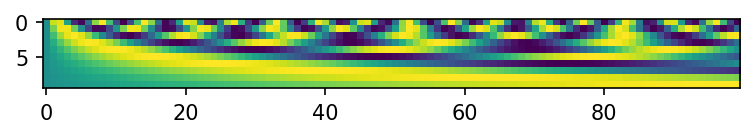

In [42]:
plt.figure(dpi=150); plt.imshow(positionalEncode(torch.zeros(100, 10)).T)

In [43]:
#export
import asyncio, functools
from threading import Timer as ThreadingTimer
class AsyncTimer: # rename if want to use
    def __init__(self, timeout, callback):
        self._timeout = timeout; self._callback = callback
    async def _job(self):
        await asyncio.sleep(self._timeout); self._callback()
    def start(self): self._task = asyncio.ensure_future(self._job())
    def cancel(self): self._task.cancel()
def debounce(wait, threading=False):
    """Decorator that will postpone a function's execution until after
``wait`` seconds have elapsed since the last time it was invoked. Taken
from `ipywidgets <https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html>`_.
Example::

    import k1lib, time; value = 0

    @k1lib.debounce(0.5, True)
    def f(x): global value; value = x**2

    f(2); time.sleep(0.3); f(3)
    print(value) # prints "0"
    time.sleep(0.7)
    print(value) # prints "9"

:param wait: wait time in seconds
:param threading: if True, use multiple threads, else just use async stuff"""
    Timer = ThreadingTimer if threading else AsyncTimer
    def decorator(fn):
        timer = None
        def debounced(*args, **kwargs):
            nonlocal timer
            if timer is not None: timer.cancel()
            timer = Timer(wait, lambda: fn(*args, **kwargs))
            timer.start()
        functools.update_wrapper(debounced, fn); return debounced
    return decorator

In [44]:
import time; value = 0
@debounce(0.5, True)
def f(x): global value; value = x**2
f(2); time.sleep(0.3); f(3); assert value == 0
time.sleep(0.7); assert value == 9

In [45]:
#export
class CaptureStdout(list):
    """Captures every print() statement. Taken from https://stackoverflow.com/questions/16571150/how-to-capture-stdout-output-from-a-python-function-call.
Example::

    with CaptureStdout() as outer:
        print("something")
        with CaptureStdout() as inner:
            print("inside inner")
        print("else")
    # prints "['something', 'else']"
    print(outer)
    # prints "['inside inner']"
    print(inner)

Note that internally, this replaces :data:`sys.stdout` as :class:`io.StringIO`, so
might not work property if you have fancy :class:`bytes` stuff going on."""
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = io.StringIO(); return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio; sys.stdout = self._stdout

In [46]:
with CaptureStdout() as testCapture:
    with CaptureStdout() as outer:
        print("something")
        with CaptureStdout() as inner:
            print("inside inner")
        print("else")
    print(outer); print(inner)
assert testCapture[0] == "['something', 'else']"
assert testCapture[1] == "['inside inner']"

In [48]:
!../export.py _basics

Current dir: /home/kelvin/repos/labs/k1lib, ../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 0.2
Uninstalling k1lib-0.2:
  Successfully uninstalled k1lib-0.2
running install
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.txt
writing manifest file 'k1lib.egg-info/SOURCES.txt'
reading manifest file 'k1lib.egg-info/SOURCES.txt'
writing manifest file 'k1lib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/k1lib
copying k1lib/_learner.py -> build/lib/k1lib
copying k1lib/data.py -> build/lib/k1lib
copying k1lib/selector.py -> build/lib/k1lib
copying k1lib/imports.py -> build/lib/k1lib
copying k1lib/_basics.py 